## Meta Models vs Final Prediction Error

In [57]:
# Define variables
IS_FILTERED = True
ARCHIVED = "error_observation_cpu"
SHOW_LAST_APPEARANCE = 30
CUT_LAST_APPEARANCE = 0

In [58]:
# Import libraries
import sys
sys.path.append('../prediction/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from putils.observation import compute_rmse, compute_mae, load_data

In [59]:
# Define plotting function
def plot_error_over_time(
        df_meta,
        df_final,
        # target_cols = ['LINEAR_REGRESSION', 'RANDOM_FOREST', 'FEEDFORWARD_NEURAL_NETWORK', 'Predicted'],
        target_cols = ['LINEAR_REGRESSION', 'RANDOM_FOREST', 'FEEDFORWARD_NEURAL_NETWORK'], # Considered only the L2 models
        error_type = 'RMSE',
    ):
    compute_error_fn = compute_rmse if error_type == 'RMSE' else compute_mae

    # Concatenating the DataFrames without renaming 'Raw' since it's the same in both
    # combined_df_simple = pd.concat([df_meta, df_final], axis=1)
    combined_df_simple = pd.concat([df_meta], axis=1) # Only use meta data
    
    # Dropping duplicate 'Raw' and 'Actual' columns from the combined DataFrame
    combined_df_no_duplicates = combined_df_simple.loc[:,~combined_df_simple.columns.duplicated()]

    # Recalculating incremental RMSE using the non-duplicate 'Raw' column
    error_over_time_no_duplicates = pd.DataFrame(index=combined_df_no_duplicates.index, columns=target_cols)

    # Compute error incrementally for each time point
    for time_point in combined_df_no_duplicates.index:
        for col in target_cols:
            # Calculate error from start to the current time point
            error_over_time_no_duplicates.at[time_point, col] = np.sqrt(
                compute_error_fn(combined_df_no_duplicates.loc[:time_point, 'Raw'], combined_df_no_duplicates.loc[:time_point, col])
            )

    # Convert error values to numeric for plotting
    error_over_time_no_duplicates = error_over_time_no_duplicates.apply(pd.to_numeric)

    # Plotting incremental error over time
    plt.figure(figsize=(12, 6))
    for col in error_over_time_no_duplicates.columns:
        plt.plot(error_over_time_no_duplicates.index, error_over_time_no_duplicates[col], label=f'{error_type} {col}')

    plt.xlabel('Time')
    plt.ylabel('RMSE')
    plt.title('Incremental RMSE of Each Model Over Time Using Non-Duplicate Raw Data')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate the dates for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
    plt.show()

    # Calculating the final error of each model for the entire dataset
    final_error_values = {}
    for col in target_cols:
        final_error_values[col] = np.sqrt(
            compute_error_fn(combined_df_no_duplicates['Raw'], combined_df_no_duplicates[col])
        )

    # Displaying the final error values for each model
    for key, value in final_error_values.items():
        print(f'Final {error_type} {key}: {value}')

    return error_over_time_no_duplicates

In [60]:
# Load data
datafile = "prediction_result_filtered.csv" if IS_FILTERED else "prediction_result.csv"
dir = "../source/"

df_meta = load_data("l2", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE)
df_final = load_data("l3", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE)

# Cut last appearance
if CUT_LAST_APPEARANCE > 0:
    df_meta = df_meta.iloc[:-CUT_LAST_APPEARANCE]
    df_final = df_final.iloc[:-CUT_LAST_APPEARANCE]

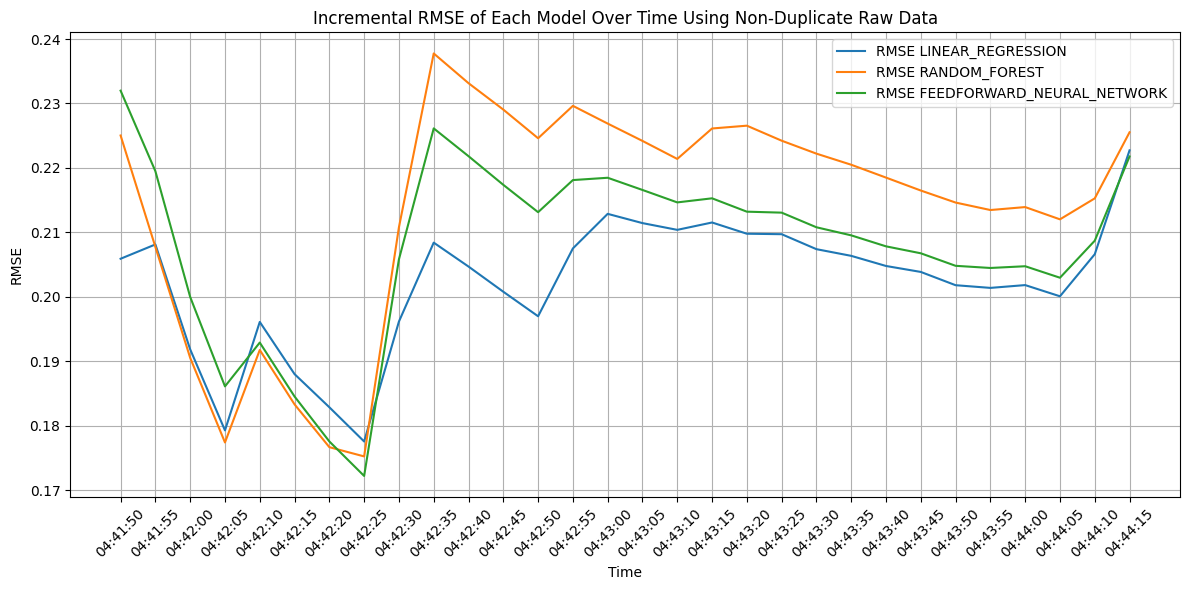

Final RMSE LINEAR_REGRESSION: 0.2227306736774736
Final RMSE RANDOM_FOREST: 0.22553346677038436
Final RMSE FEEDFORWARD_NEURAL_NETWORK: 0.22177863639966858


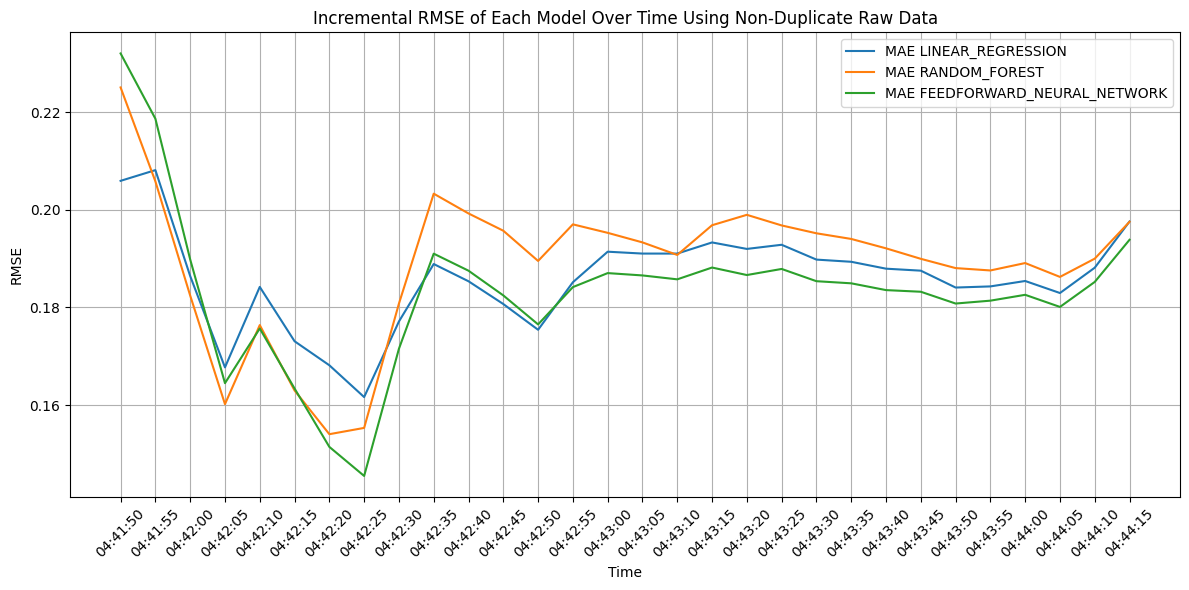

Final MAE LINEAR_REGRESSION: 0.19758203318364329
Final MAE RANDOM_FOREST: 0.19752164438359657
Final MAE FEEDFORWARD_NEURAL_NETWORK: 0.193840400784225


,LINEAR_REGRESSION,RANDOM_FOREST,FEEDFORWARD_NEURAL_NETWORK
FormattedTime,,,
04:41:50,0.205907,0.225033,0.231993
04:41:55,0.208103,0.205791,0.218627
04:42:00,0.186410,0.182416,0.189809
04:42:05,0.167705,0.160177,0.164470
04:42:10,0.184184,0.176366,0.175669
04:42:15,0.173059,0.162978,0.163377
04:42:20,0.168136,0.154024,0.151424
04:42:25,0.161624,0.155310,0.145472
04:42:30,0.177107,0.180769,0.171522


In [61]:
# Plot error over time
errors = plot_error_over_time(df_meta, df_final, error_type='RMSE')
plot_error_over_time(df_meta, df_final, error_type='MAE')

In [62]:
# save data to csv
file = f"error_over_time_{ARCHIVED}.csv"
errors.to_csv(file)